In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression

Dataset: https://www.kaggle.com/datasets/ahsan81/food-ordering-and-delivery-app-dataset/data

In [2]:
df = pd.read_csv("data/food_order.csv")

In [3]:
df

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24
...,...,...,...,...,...,...,...,...,...
1893,1476701,292602,Chipotle Mexican Grill $1.99 Delivery,Mexican,22.31,Weekend,5,31,17
1894,1477421,397537,The Smile,American,12.18,Weekend,5,31,19
1895,1477819,35309,Blue Ribbon Sushi,Japanese,25.22,Weekday,Not given,31,24
1896,1477513,64151,Jack's Wife Freda,Mediterranean,12.18,Weekday,5,23,31


In [4]:
print(f"Number of customers are {len(df.customer_id.value_counts())}")

Number of customers are 1200


In [5]:
print(f"Number of orders are {len(df.order_id.value_counts())}")

Number of orders are 1898


In [6]:
print(f"Number of restaurants are {len(df.restaurant_name.value_counts())}")

Number of restaurants are 178


### Objective

The food aggregator company has stored the data of the different orders made by the registered customers in their online portal. They want to analyze the data to get a fair idea about the demand of different restaurants which will help them in enhancing their customer experience. Suppose you are hired as a Data Scientist in this company and the Data Science team has shared some of the key questions that need to be answered. Perform the data analysis to find answers to these questions that will help the company to improve the business.

### Questions
1. Which restaurant receives the highest orders? And what is the demand accross other restaurants?
2. What is the average cost of orders made for each restaurant? And does cost have effect on patronage?
3. What is the standard deviation of food preparation time for each restaurant and does this have effect on patronage?
4. Which customers have made the most orders? And what is the average/variance delivery time to this customer?
5. What is the best restaurant according to rating?
6. What is the best cuisine according to rating?
7. What is the distribution of the cost of orders, food prepration time and delivery time
8. Are there missing data, duplicates or outliers in the data?

### 1.  Which restaurant receives the highest orders? And what is the demand accross other restaurants?

In [7]:
restaurant_counts = {}
for name, group in df.groupby("restaurant_name"):
    restaurant_counts[name] = len(group["order_id"])


In [8]:
print(f"There are {len(restaurant_counts)} restaurants in total")

There are 178 restaurants in total


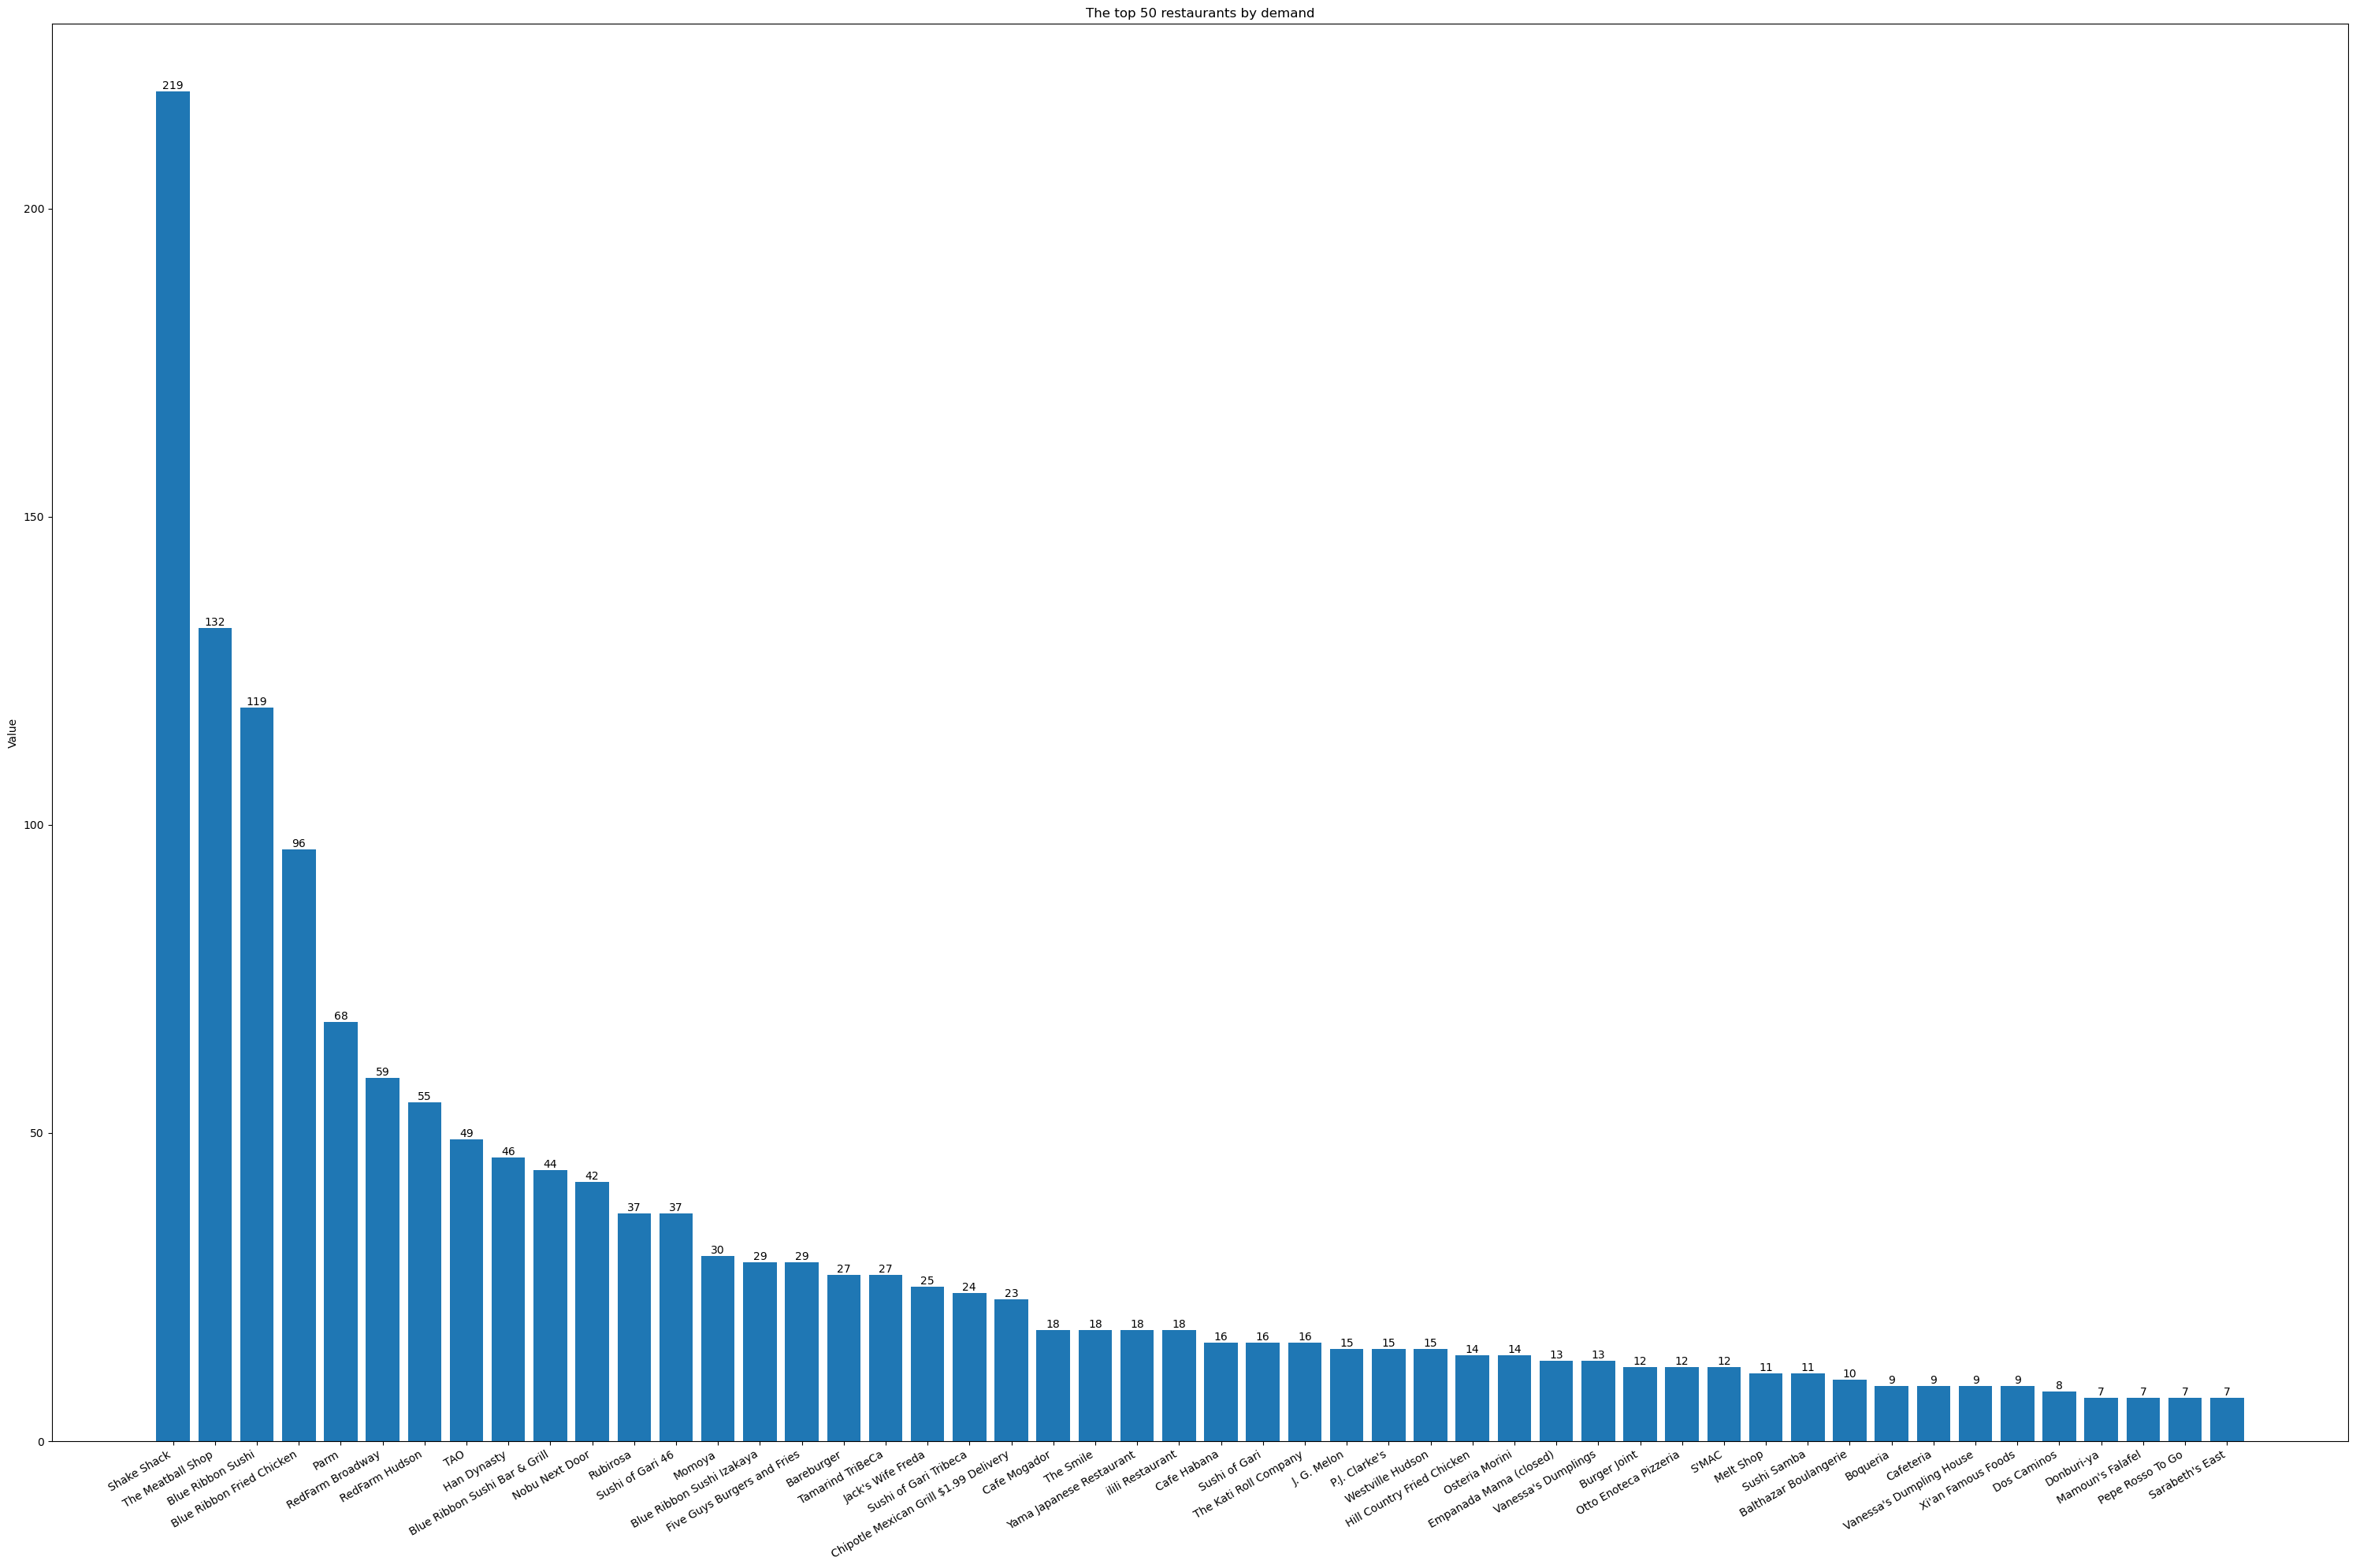

In [9]:
#Because of legibility, I selected only the top 50 restaurants
items = sorted(restaurant_counts.items(), key=lambda kv: kv[1], reverse=True)
top50 = items[:50]
labels, values = zip(*top50)

plt.figure(figsize=(30,20))
x = range(len(labels))
plt.bar(x, values)

# annotate each bar with its value
for i, v in enumerate(values):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Value")
plt.title("The top 50 restaurants by demand")
plt.tight_layout()
plt.show()

Shake Shack has the highest order with 219 orders, that is 11.54% of total orders

### 2. What is the average cost of orders made for each restaurant? And does cost have effect on patronage?

In [10]:
restaurant_costs = {}
for name, group in df.groupby("restaurant_name"):
    restaurant_costs[name] = round(group["cost_of_the_order"].mean(),2)

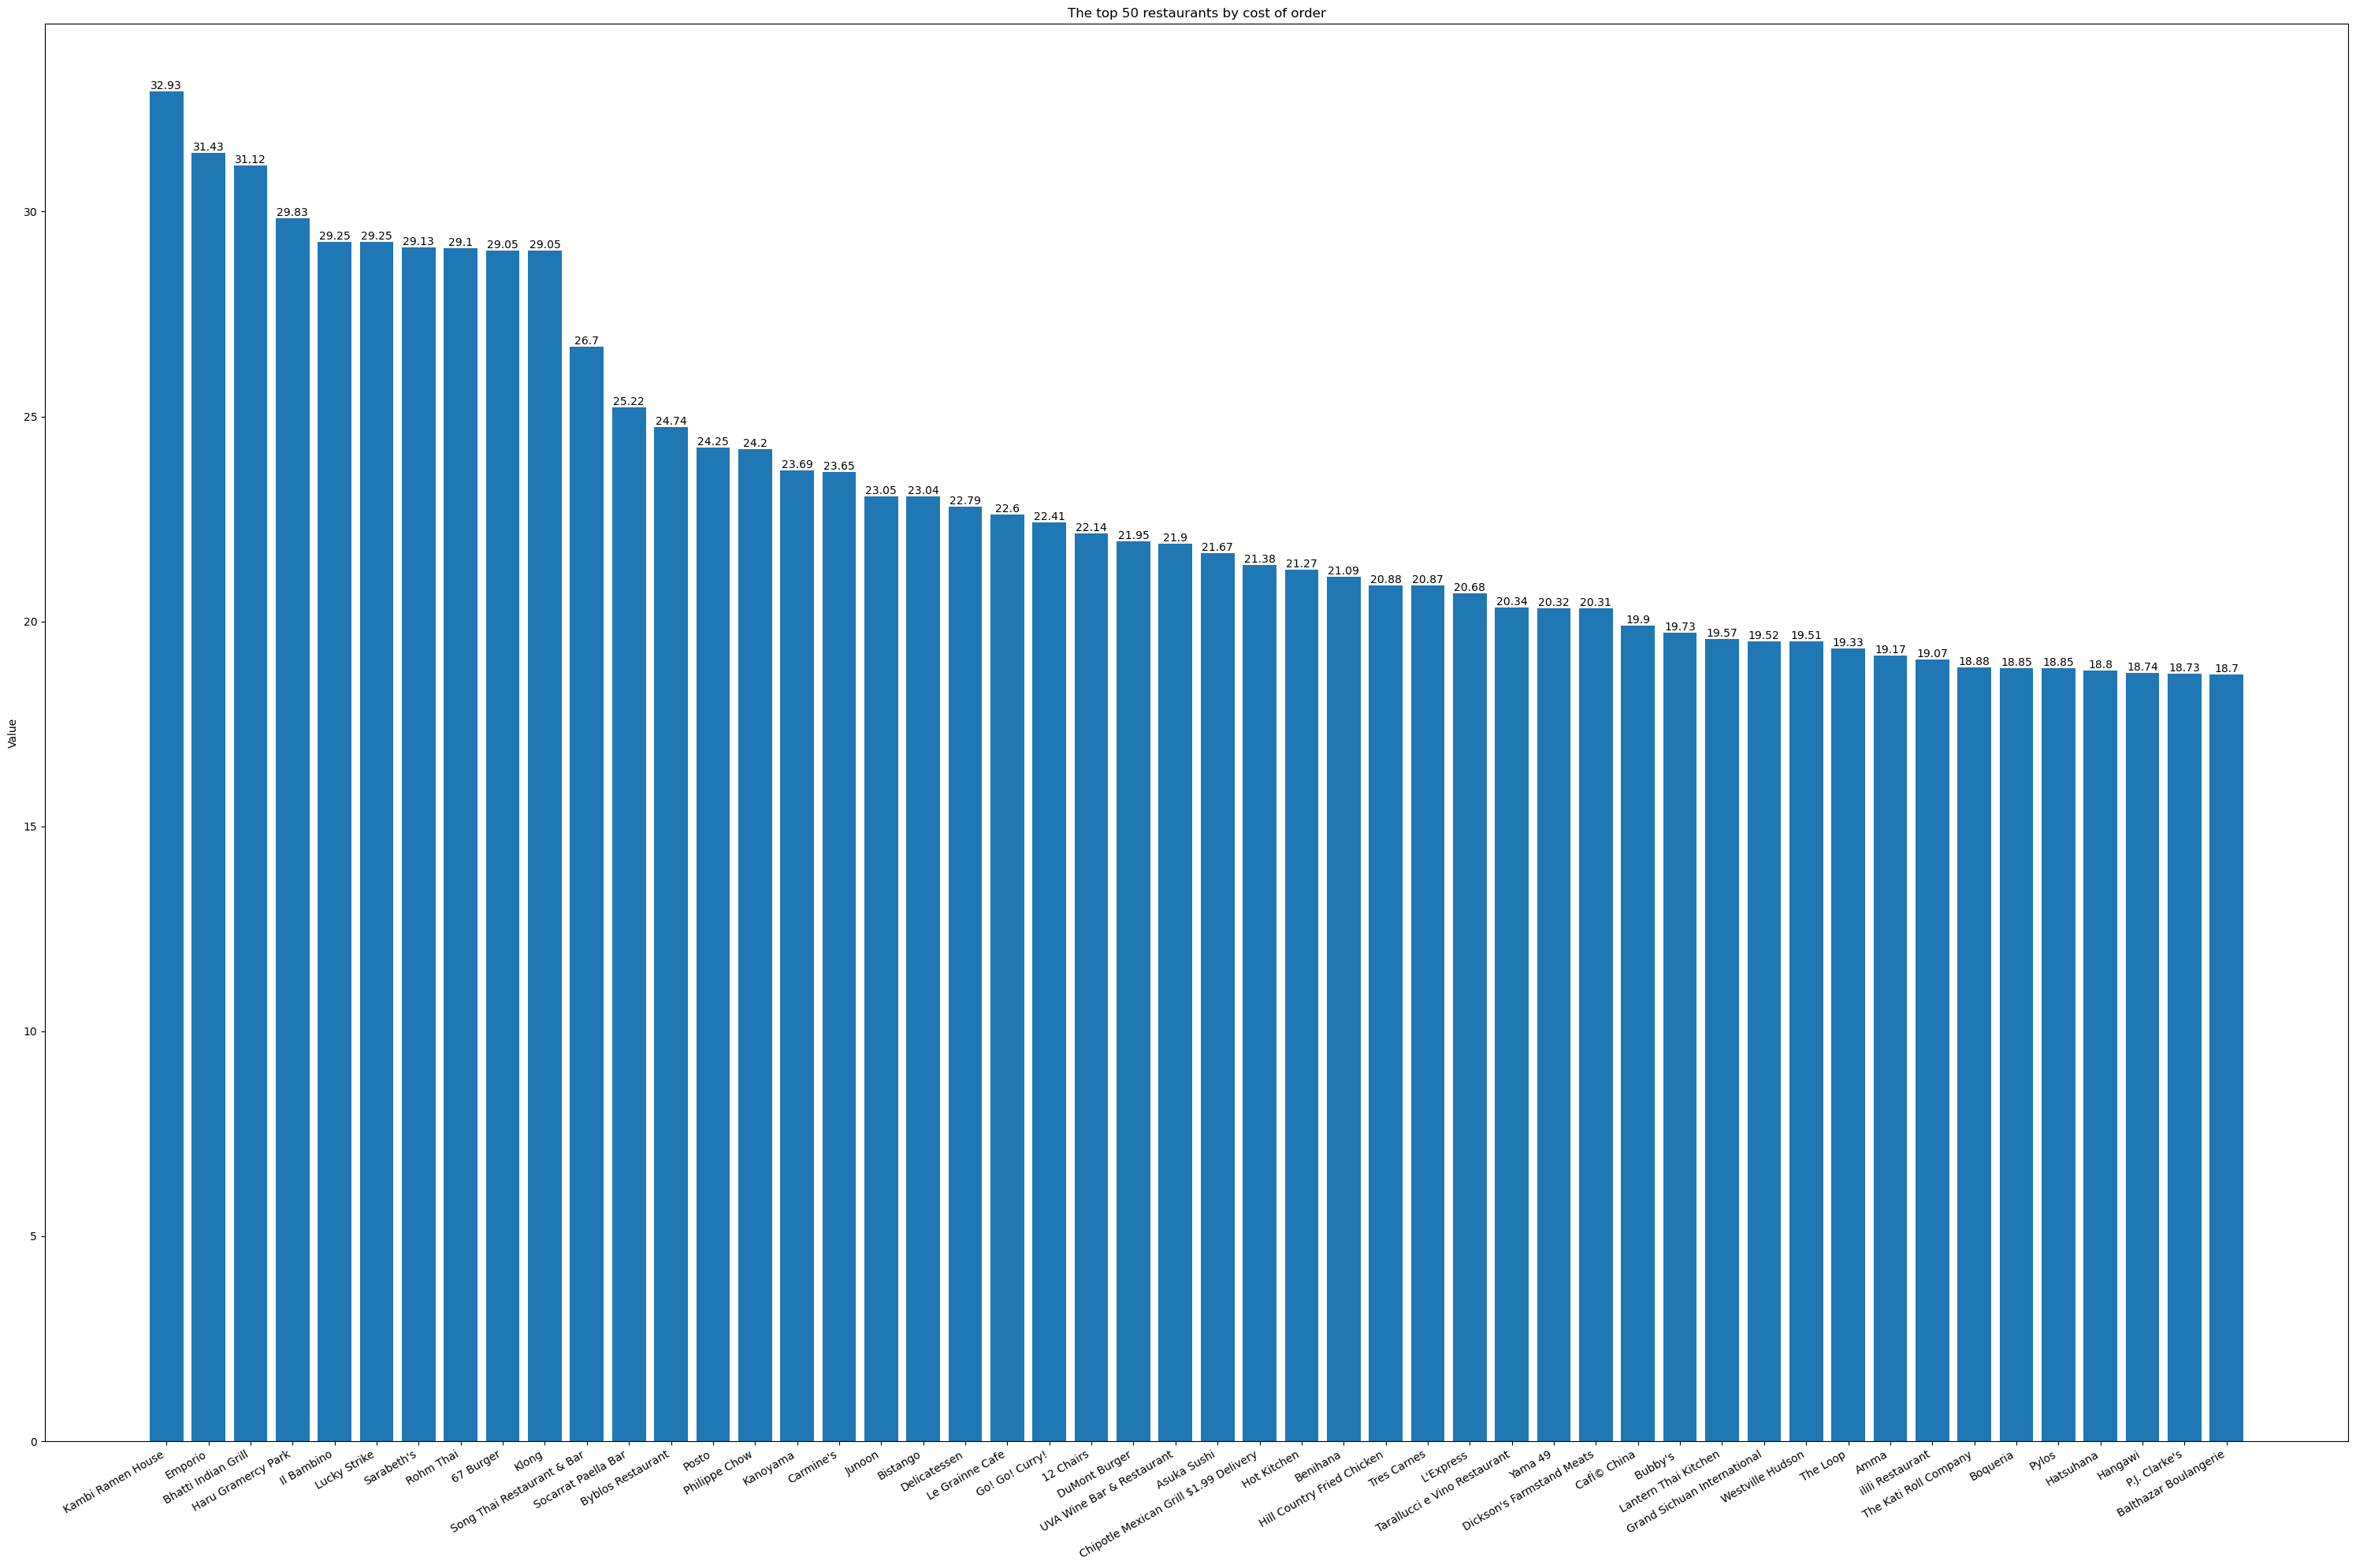

In [11]:
#Because of legibility, I selected only the top 50 restaurants
items = sorted(restaurant_costs.items(), key=lambda kv: kv[1], reverse=True)
top50 = items[:50]
labels, values = zip(*top50)

plt.figure(figsize=(30,20))
x = range(len(labels))
plt.bar(x, values)

# annotate each bar with its value
for i, v in enumerate(values):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Value")
plt.title("The top 50 restaurants by cost of order")
plt.tight_layout()
plt.show()

In [12]:
restaurant_avg_costs_orders = {}
for name, group in df.groupby("restaurant_name"):
    restaurant_avg_costs_orders[name] = [
        group["order_id"].nunique(),                 # count orders
        round(group["cost_of_the_order"].mean(), 2)  # avg cost
    ]

per_rest = (pd.DataFrame.from_dict(restaurant_avg_costs_orders, orient="index",
                                   columns=["order_count", "avg_cost"])
              .reset_index()
              .rename(columns={"index": "restaurant_name"}))


        

In [13]:
per_rest

,restaurant_name,order_count,avg_cost
0,'wichcraft,1,8.10
1,12 Chairs,4,22.14
2,5 Napkin Burger,5,15.97
3,67 Burger,1,29.05
4,Alidoro,1,12.61
...,...,...,...
173,Zero Otto Nove,2,9.02
174,brgr,2,9.90
175,da Umberto,3,17.62
176,ilili Restaurant,18,19.07


In [14]:
r, p = pearsonr(per_rest["order_count"], per_rest["avg_cost"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = -0.003, p = 0.964


Therefore, there is no statistically significant relationship between restaurant cost and number of orders.

### 3. What is the standard deviation of food preparation time for each restaurant and does this have effect on patronage?

In [15]:
restaurant_stds = {}
for name, group in df.groupby("restaurant_name"):
    std = group["food_preparation_time"].std()
    if pd.notna(std):  
        restaurant_stds[name] = round(std, 2)  # avg cost
    

In [16]:
restaurant_stds;

/var/folders/mt/mxjgxl111qq30xtvb88fksnw0000gn/T/ipykernel_64590/870757044.py:17: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/oluwadaraadedeji/anaconda3/envs/ml-zc-project/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


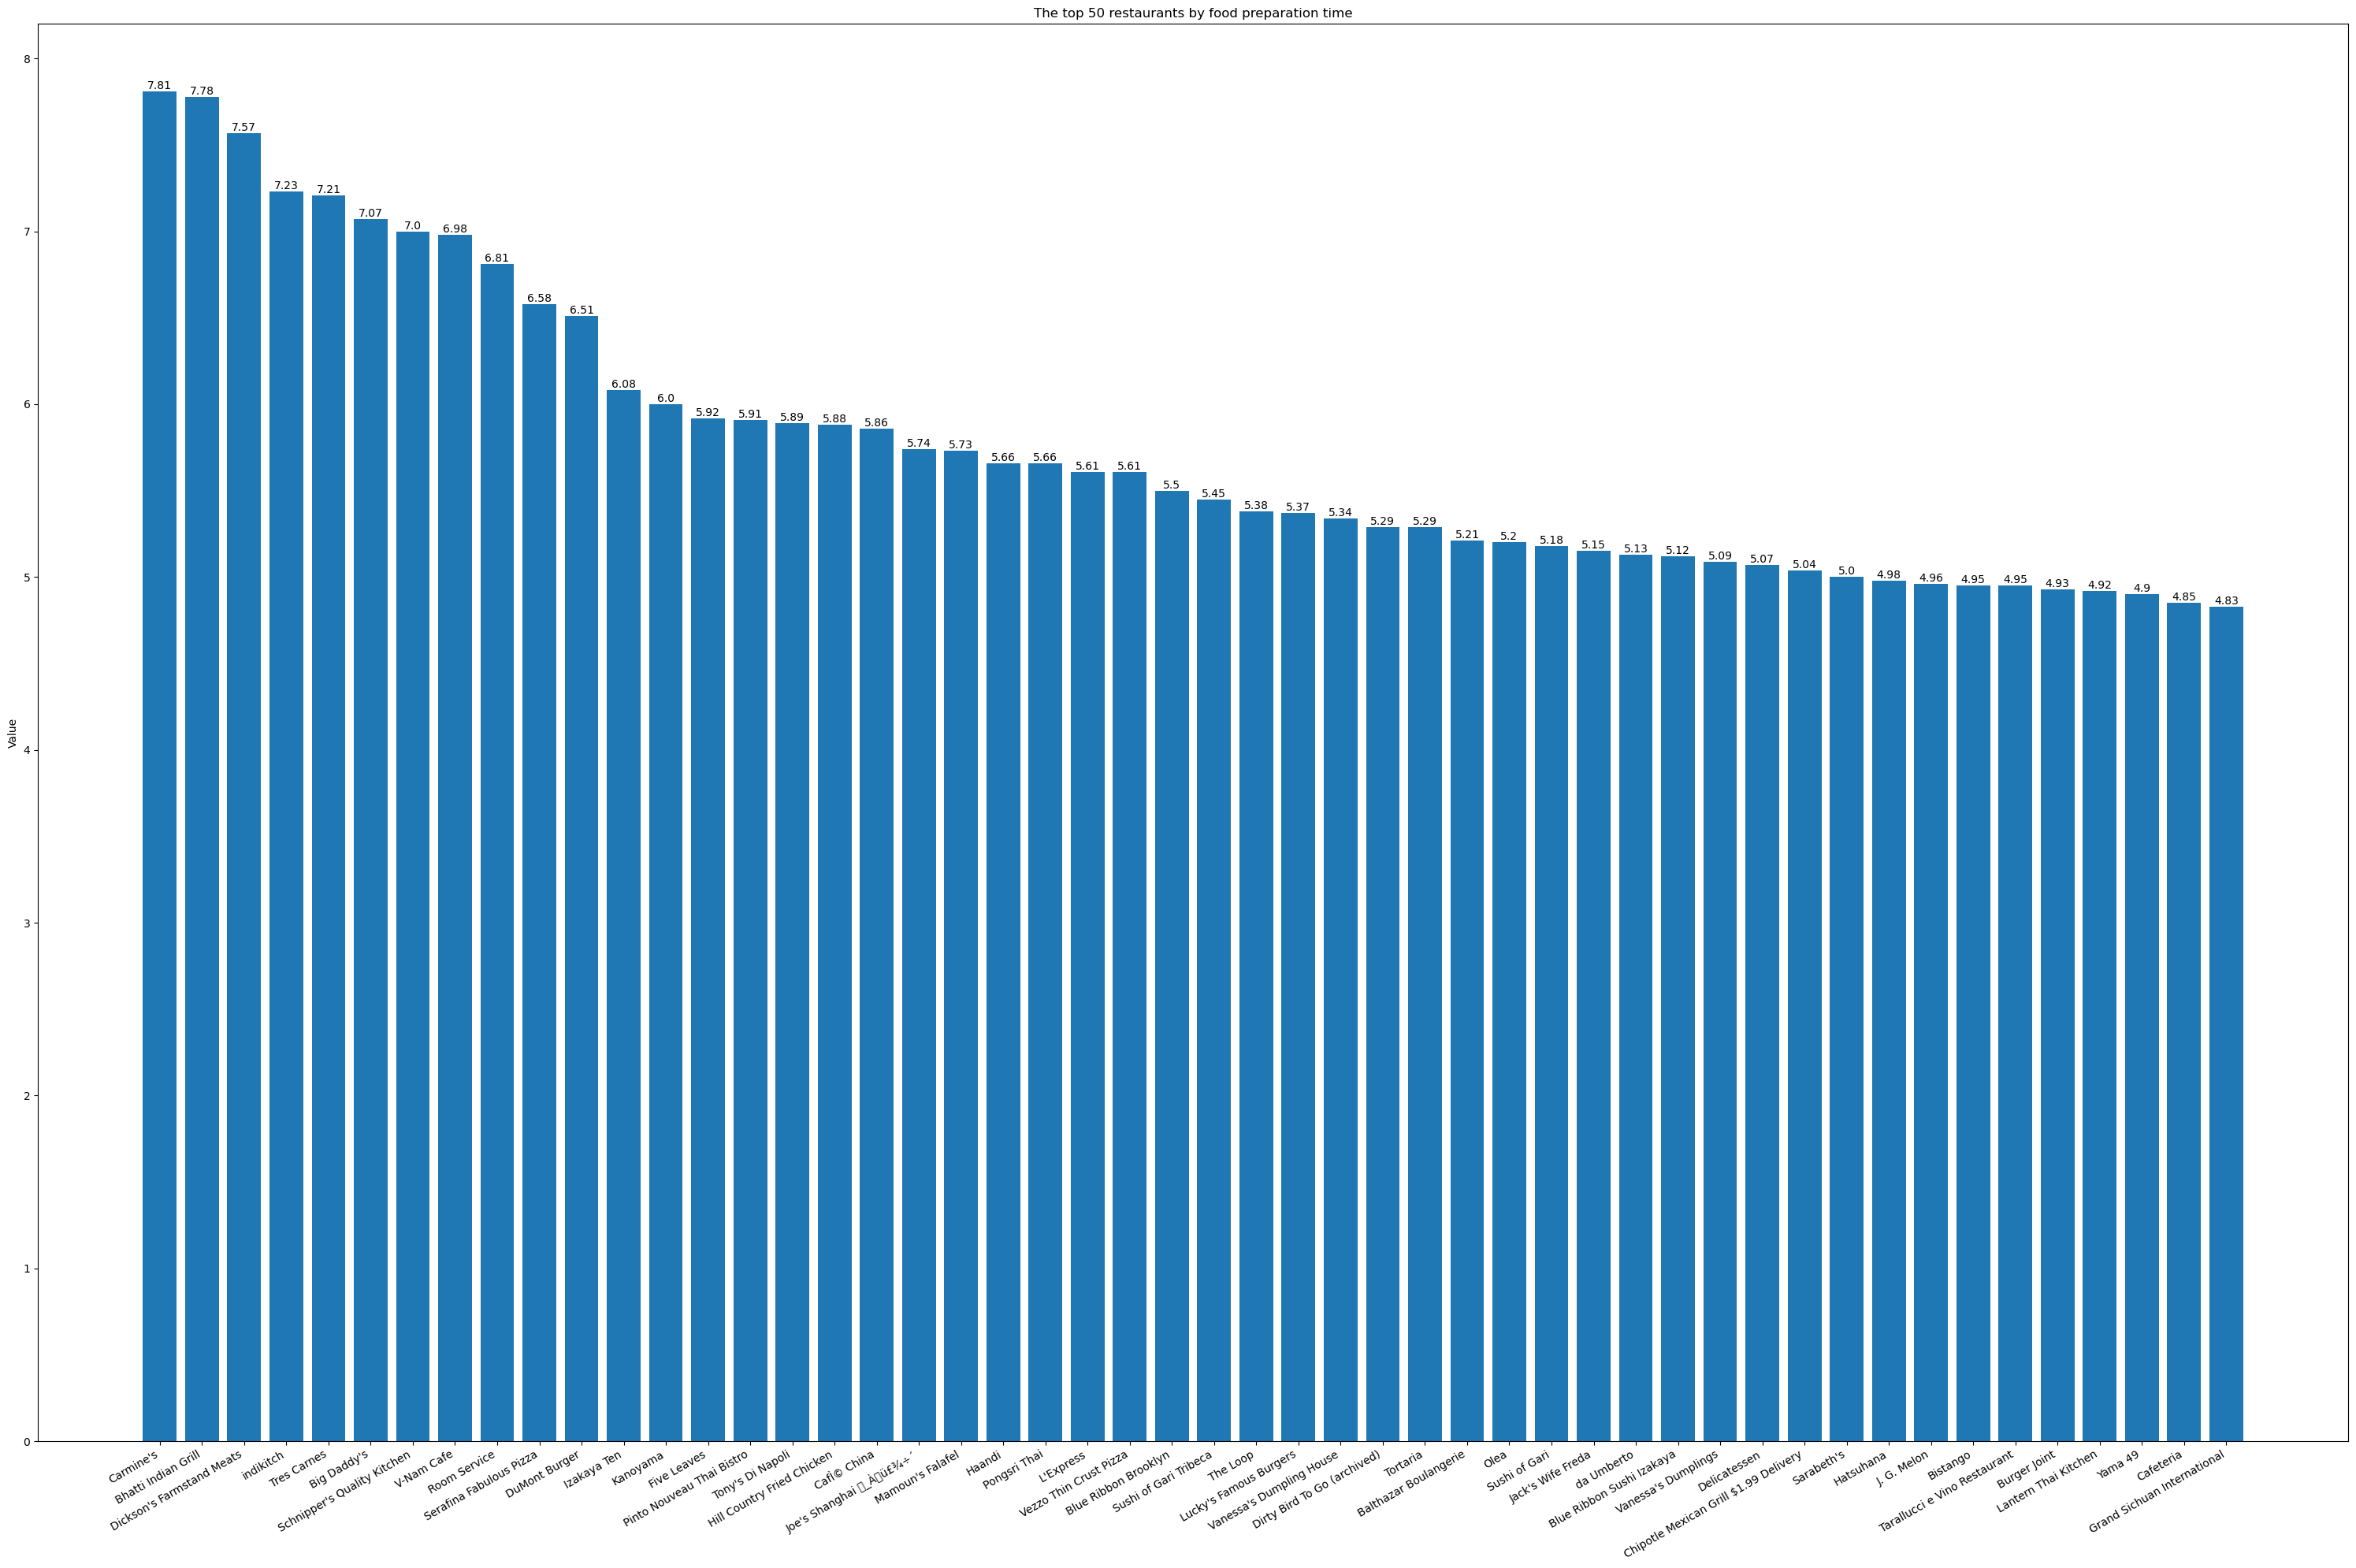

In [17]:
#Because of legibility, I selected only the top 50 restaurants
items = sorted(restaurant_stds.items(), key=lambda kv: kv[1], reverse=True)
top50 = items[:50]
labels, values = zip(*top50)

plt.figure(figsize=(30,20))
x = range(len(labels))
plt.bar(x, values)

# annotate each bar with its value
for i, v in enumerate(values):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Value")
plt.title("The top 50 restaurants by food preparation time")
plt.tight_layout()
plt.show()

In [18]:
restaurant_std_prep_orders = {}
for name, group in df.groupby("restaurant_name"):
    std = group["food_preparation_time"].std()
    if pd.notna(std): 
        restaurant_std_prep_orders[name] = [
            group["order_id"].nunique(),                 # count orders
            round(std, 2)  # std
        ]

per_rest = (pd.DataFrame.from_dict(restaurant_std_prep_orders, orient="index",
                                   columns=["order_count", "preparation_time_std"])
              .reset_index()
              .rename(columns={"index": "restaurant_name"}))


In [19]:
per_rest

,restaurant_name,order_count,preparation_time_std
0,12 Chairs,4,3.74
1,5 Napkin Burger,5,4.09
2,Amma,4,4.35
3,Amy Ruth's,3,4.16
4,Asuka Sushi,3,3.61
...,...,...,...
123,Zero Otto Nove,2,1.41
124,brgr,2,1.41
125,da Umberto,3,5.13
126,ilili Restaurant,18,3.27


In [20]:
r, p = pearsonr(per_rest["order_count"], per_rest["preparation_time_std"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = 0.076, p = 0.393


There is a slight positive correlation between the standard deviation of the food preparation time and the number of orders which are received. Probing further, I check if the average preparation time has an effect on the number of orders received./

In [21]:
restaurant_mean_prep_orders = {}
for name, group in df.groupby("restaurant_name"):
    mean = group["food_preparation_time"].mean()
    if pd.notna(mean): 
        restaurant_mean_prep_orders[name] = [
            group["order_id"].nunique(),                 # count orders
            round(mean, 2)  # std
        ]

per_rest = (pd.DataFrame.from_dict(restaurant_mean_prep_orders, orient="index",
                                   columns=["order_count", "preparation_time_mean"])
              .reset_index()
              .rename(columns={"index": "restaurant_name"}))

In [22]:
per_rest

,restaurant_name,order_count,preparation_time_mean
0,'wichcraft,1,28.00
1,12 Chairs,4,27.00
2,5 Napkin Burger,5,30.20
3,67 Burger,1,20.00
4,Alidoro,1,34.00
...,...,...,...
173,Zero Otto Nove,2,30.00
174,brgr,2,25.00
175,da Umberto,3,24.33
176,ilili Restaurant,18,26.39


In [23]:
r, p = pearsonr(per_rest["order_count"], per_rest["preparation_time_mean"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = 0.019, p = 0.798


Again, the average preparation time of each restaurant does not have any effect on the number of orders they receive. This is surprising given that it would be expected that longer preparation time might cause customers not to want to wait. However, from analysis, it shows that participants stick to their cuisines irrespective of preparation time. This could be based on the nationality background of the participants. It is also possible that the customers are situated close to the restaurant resulting in lower delivery time.

### 4. Which customers have made the most orders? And what is the average/variance delivery time to this customer?

In [24]:
restaurant_customer_orders = {}
for name, group in df.groupby("customer_id"):
    restaurant_customer_orders[name] = [
        group["order_id"].nunique(),                 # count orders
        round(group["delivery_time"].mean(), 2)  # avg delivery
    ]

per_customer = (pd.DataFrame.from_dict(restaurant_customer_orders, orient="index",
                                   columns=["order_count", "avg_delivery"])
              .reset_index()
              .rename(columns={"index": "customer_id"}))

In [25]:
per_customer

,customer_id,order_count,avg_delivery
0,1311,1,26.0
1,5139,1,22.0
2,5444,1,29.0
3,5693,1,32.0
4,6987,2,31.0
...,...,...,...
1195,402215,1,25.0
1196,403019,1,32.0
1197,403833,1,32.0
1198,404649,1,28.0


In [26]:
max_order = per_customer["order_count"].max()

In [27]:
max_order

13

In [28]:
# To check if multiple customers made 13 orders. We see that only one customer made 13 orders
per_customer["order_count"].value_counts()

order_count
1     784
2     267
3      83
4      33
5      19
6       6
7       4
10      1
13      1
9       1
8       1
Name: count, dtype: int64

In [29]:
max_customer = per_customer[per_customer["order_count"] == max_order]["customer_id"].iloc[0]

In [30]:
print(f"The customer with the max order is customer with id {max_customer}")

The customer with the max order is customer with id 52832


In [32]:
r, p = pearsonr(per_customer["order_count"], per_customer["avg_delivery"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = -0.015, p = 0.605


From the correlation and p-value, we also see that there is no statistically significant correlation between the order made by customers and the average delivery time to those customers

### 5. What is the best restaurant according to rating?

In [33]:
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

restaurant_ratings = {}
for name, group in df.groupby("restaurant_name"):
    ratings = group["rating"].mean()
    if pd.notna(ratings):
        restaurant_ratings[name] = round(ratings, 2)  # avg delivery
    

In [34]:
restaurant_ratings;

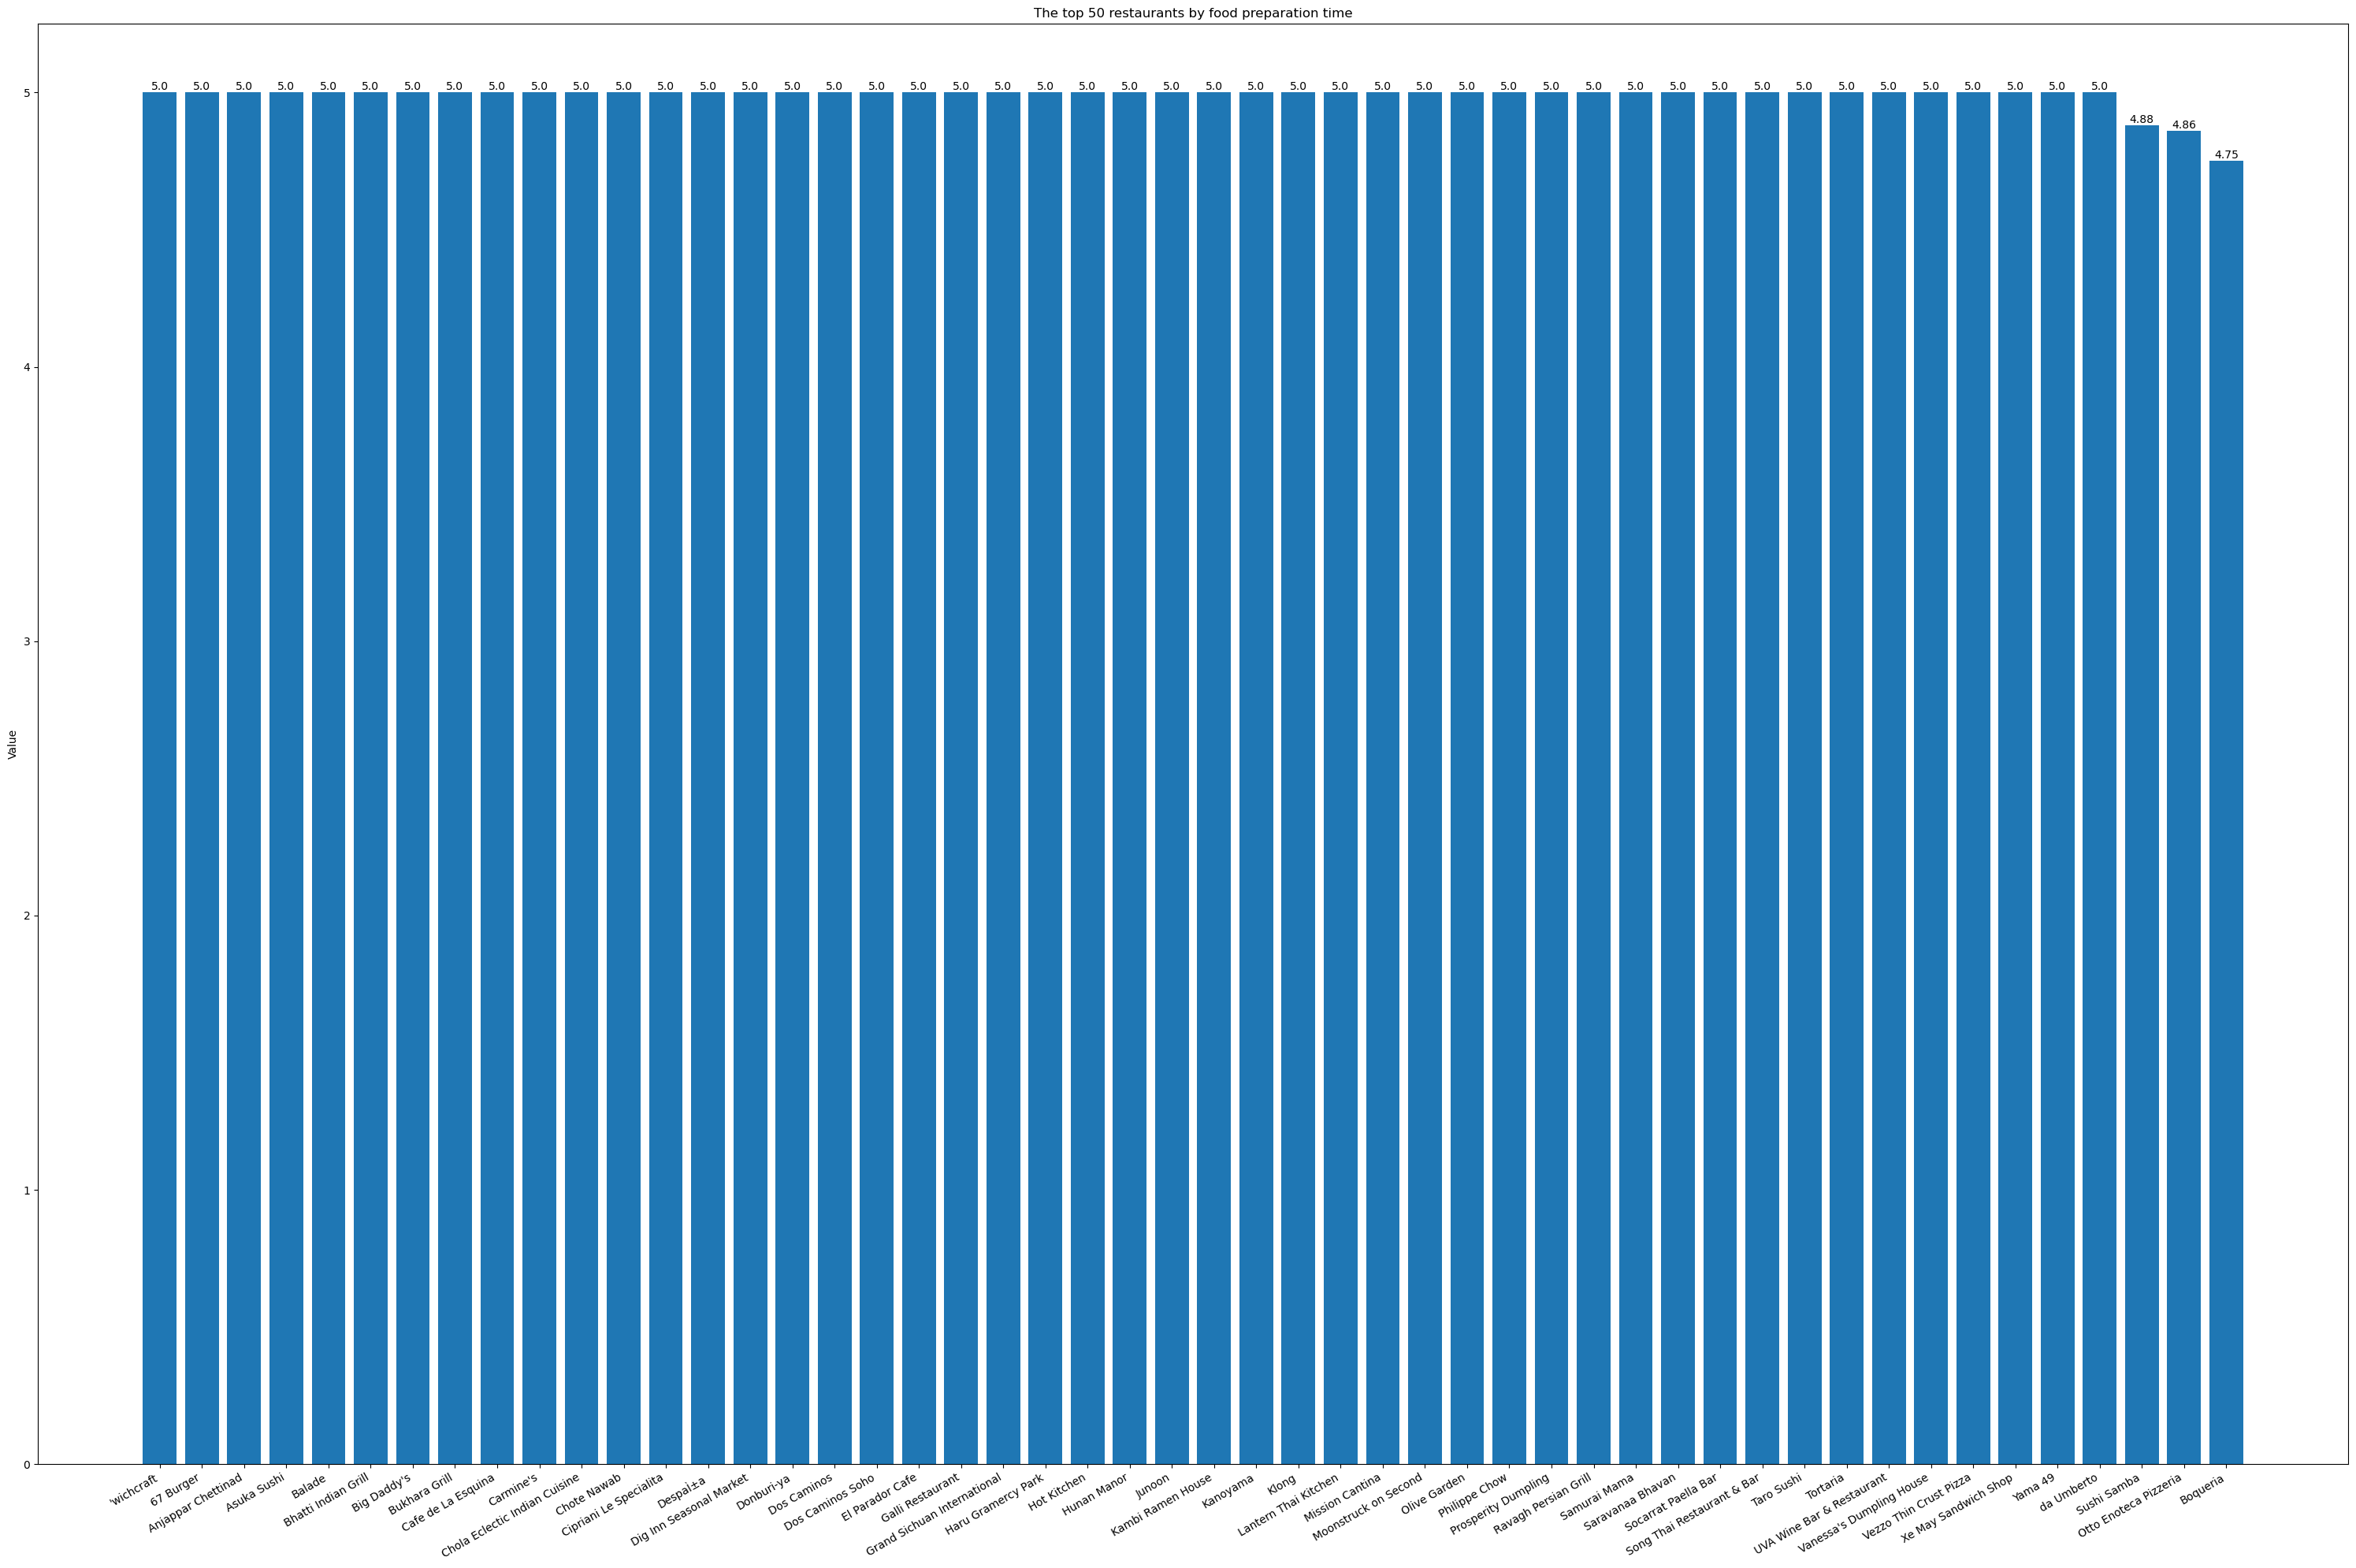

In [35]:
items = sorted(restaurant_ratings.items(), key=lambda kv: kv[1], reverse=True)
top50 = items[:50]
labels, values = zip(*top50)

plt.figure(figsize=(30,20))
x = range(len(labels))
plt.bar(x, values)

# annotate each bar with its value
for i, v in enumerate(values):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Value")
plt.title("The top 50 restaurants by food preparation time")
plt.tight_layout()
plt.show()

In [39]:
restaurant_ratings = {}
for name, group in df.groupby("restaurant_name"):
    ratings = group["rating"].mean()
    if pd.notna(ratings):
        restaurant_ratings[name] = [
            group["order_id"].nunique(),                 # count orders
            round(ratings, 2)  # avg ratings
        ]

per_rest = (pd.DataFrame.from_dict(restaurant_ratings, orient="index",
                                   columns=["order_count", "ratings"])
              .reset_index()
              .rename(columns={"index": "restaurant"}))

In [40]:
per_rest

,restaurant,order_count,ratings
0,'wichcraft,1,5.00
1,12 Chairs,4,4.50
2,5 Napkin Burger,5,4.00
3,67 Burger,1,5.00
4,Amma,4,4.50
...,...,...,...
151,Zero Otto Nove,2,4.00
152,brgr,2,3.00
153,da Umberto,3,5.00
154,ilili Restaurant,18,4.15


In [41]:
r, p = pearsonr(per_rest["order_count"], per_rest["ratings"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = -0.042, p = 0.606


There is no statistically significant correlation between ratings and the number of orders made

### 6. What is the best cuisine according to rating? 

In [43]:
restaurant_ratings = {}
for name, group in df.groupby("cuisine_type"):
    ratings = group["rating"].mean()
    if pd.notna(ratings):
        restaurant_ratings[name] = [
            group["order_id"].nunique(),                 # count orders
            round(ratings, 2)  # avg ratings
        ]

per_cuisine = (pd.DataFrame.from_dict(restaurant_ratings, orient="index",
                                   columns=["order_count", "ratings"])
              .reset_index()
              .rename(columns={"index": "cuisine_type"}))

In [44]:
per_cuisine

,cuisine_type,order_count,ratings
0,American,584,4.30
1,Chinese,215,4.34
2,French,18,4.30
3,Indian,73,4.54
4,Italian,298,4.36
5,Japanese,470,4.37
6,Korean,13,4.11
7,Mediterranean,46,4.22
8,Mexican,77,4.42
9,Middle Eastern,49,4.24


As we can see from the data, American cuisine type has the highest number of order_counts, despite a rating of 4.30. Considering the large number of orders, this is a very good rating. The Spanish cuisine which has the highest rating has just 12 orders. This might be an indication of the popularism of the Spanish cuisine, and the restaurant might be in America.

In [46]:
r, p = pearsonr(per_cuisine["order_count"], per_cuisine["ratings"])
print(f"r = {r:.3f}, p = {p:.3g}")

r = -0.041, p = 0.889


It is evident that there is no statistically significant correlation between cuisine type and the number of orders made

### 7. What is the distribution of the cost of orders, food prepration time and delivery time

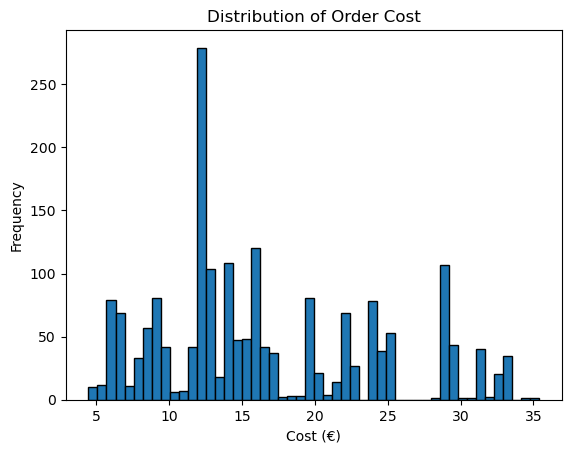

In [49]:
plt.hist(df["cost_of_the_order"], bins=50, edgecolor='black')
plt.title("Distribution of Order Cost")
plt.xlabel("Cost ($)")
plt.ylabel("Frequency")
plt.show()

- The distribution is highly right-skewed (positively skewed) — there’s a strong concentration of orders around €10–15, and the frequency drops off sharply as cost increases.
- You can also see some secondary small peaks near 20 dollars and 30 dollars, but those are much less frequent.
- The most common order cost (mode) lies around \$10–12, where the tallest bar (≈250+ frequency) appears.
- The mean is likely slightly higher (maybe around \$13–15) because the right tail (more expensive orders) pulls the average up.
- The median will be lower than the mean (another sign of right-skew).
- Order costs range roughly from 5 dollars to 35 dollars, giving a range of ~\$30.
- The majority of orders fall under $20, with a few high-cost outliers.

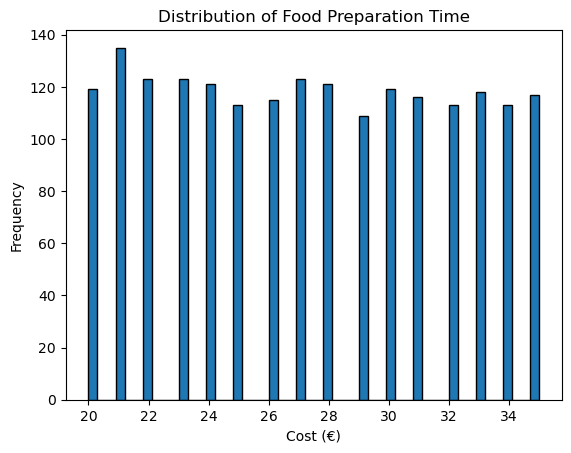

In [51]:
plt.hist(df["food_preparation_time"], bins=50, edgecolor='black')
plt.title("Distribution of Food Preparation Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
plt.show()

- The histogram is fairly flat and uniform, with frequencies across most time intervals (≈20–35 minutes) being roughly similar — around 110–130 counts each.
- There’s no sharp peak or clear mode, which means food preparation times are evenly distributed within that range.
- Food preparation times span from about 20 minutes to 35 minutes, showing a moderate range (~15 minutes).
- There’s no strong clustering around any single time window — prep times vary substantially across orders or restaurants.
- A nearly uniform distribution suggests that there’s no dominant or typical preparation time — restaurants likely vary widely in how long food takes to prepare.

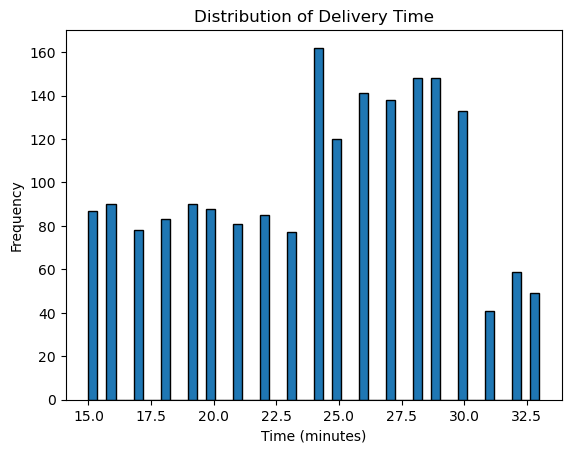

In [53]:
plt.hist(df["delivery_time"], bins=50, edgecolor='black')
plt.title("Distribution of Delivery Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
plt.show()

- The histogram appears roughly unimodal (one main peak) centered around 25–28 minutes.
- The counts drop at both ends (below 18 minutes and above 30 minutes).
- So, it’s somewhat bell-shaped, but not perfectly symmetric — maybe slightly right-skewed (a few longer delivery times).
- The most common (modal) delivery times are around 25–28 minutes, where frequency peaks (≈150–160).
- That suggests the average delivery time likely falls near that same range.
- Delivery times range roughly from 15 to 33 minutes, so there’s a range of about 18 minutes.
- That’s a moderate spread — most deliveries are within about 10 minutes of the mean.
- There’s a small tail above 30 minutes — those are the longest deliveries, possibly due to traffic, distance, or order complexity.
- Few deliveries occur under 18 minutes, so ultra-fast deliveries are rare.

### 8. Are there missing data, duplicates or outliers in the data?

In [55]:
df.describe()

,order_id,customer_id,cost_of_the_order,rating,food_preparation_time,delivery_time
count,1.898000e+03,1898.000000,1898.000000,1162.000000,1898.000000,1898.000000
mean,1.477496e+06,171168.478398,16.498851,4.344234,27.371970,24.161749
std,5.480497e+02,113698.139743,7.483812,0.741478,4.632481,4.972637
min,1.476547e+06,1311.000000,4.470000,3.000000,20.000000,15.000000
25%,1.477021e+06,77787.750000,12.080000,4.000000,23.000000,20.000000
50%,1.477496e+06,128600.000000,14.140000,5.000000,27.000000,25.000000
75%,1.477970e+06,270525.000000,22.297500,5.000000,31.000000,28.000000
max,1.478444e+06,405334.000000,35.410000,5.000000,35.000000,33.000000


This shows the min, max, media (50%) and counts across the different columns

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               1898 non-null   int64  
 1   customer_id            1898 non-null   int64  
 2   restaurant_name        1898 non-null   object 
 3   cuisine_type           1898 non-null   object 
 4   cost_of_the_order      1898 non-null   float64
 5   day_of_the_week        1898 non-null   object 
 6   rating                 1162 non-null   float64
 7   food_preparation_time  1898 non-null   int64  
 8   delivery_time          1898 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 133.6+ KB


In [57]:
df.isnull().sum()

order_id                   0
customer_id                0
restaurant_name            0
cuisine_type               0
cost_of_the_order          0
day_of_the_week            0
rating                   736
food_preparation_time      0
delivery_time              0
dtype: int64

##### We can see that only the rating has missing values. The number is substantial, so we will consider dropping this in modelling

In [58]:
df["rating"].corr(df["food_preparation_time"])

-0.006082836149954009

In [62]:
# To confirm the values in rating and there is na
df["rating"].unique()

array([nan,  5.,  3.,  4.])

##### We also see there is little correlation between the rating and food preparation time. Now, we check the mutual information between the two columns

In [66]:
# ensure numeric & drop NaNs
sub = (df[["rating", "food_preparation_time"]]
       .apply(pd.to_numeric, errors="coerce")
       .dropna())

X = sub[["rating"]]                  
y = sub["food_preparation_time"]    

mi = mutual_info_regression(X, y, random_state=0)
print(f"MI(rating to food_preparation_time) = {mi[0]:.4f}")

MI(rating to food_preparation_time) = 0.0000


##### This means the two columns are independent and giving the rating, we cannot say anything about the food preparation time. The verdict is therefore to drop this column

#####  To check duplicates

In [67]:
df.duplicated().any()

False

There are no duplicates in the data. We check for duplicates so as the model not to be biased or overfitted towards repeated observations.